In [1]:
!pip install capytaine #uncomment if first time running


import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force

import time

In [3]:
solver = cpt.BEMSolver()
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_body(d, a, fdensity, cdensity):

    zt = np.linspace(0,0,fdensity)
    rt = np.linspace(0, a[-1], fdensity)
    # top_surface = body_from_profile(rt, rt, zt, cdensity)

    zb = np.linspace(- d[0], - d[0], fdensity)
    rb = np.linspace(0, a[0], fdensity)
    bot_surface = body_from_profile(rb, rb, zb, cdensity)

    zo = np.linspace(- d[-1], 0, fdensity)
    ro = np.linspace(a[-1], a[-1], fdensity)
    outer_surface = body_from_profile(ro, ro, zo, cdensity)

    bod = bot_surface + outer_surface # + top_surface

    for i in range(1, len(a)):
      # make sides
      zs = np.linspace(- d[i-1], - d[i], fdensity)
      rs = np.linspace(a[i-1], a[i-1], fdensity)
      side = body_from_profile(rs, rs, zs ,cdensity)

      # make bottoms
      zb = np.linspace(- d[i], - d[i], fdensity)
      rb = np.linspace(a[i-1], a[i], fdensity)
      bot = body_from_profile(rb, rb, zb ,cdensity)

      (side + bot).show_matplotlib

      bod = bod + side + bot

    return bod

def rb_solve(d, a, fdensity, cdensity, rho):
  body = make_body(d, a, fdensity, cdensity)

  body.add_translation_dof(name='Heave')
  body = body.immersed_part()

  body.show_matplotlib()


  rad_problem = cpt.RadiationProblem(body=body, wavenumber = w, water_depth=h, rho = rho)
  results = solver.solve(rad_problem, keep_details = True)
  return results , body.mesh.nb_faces



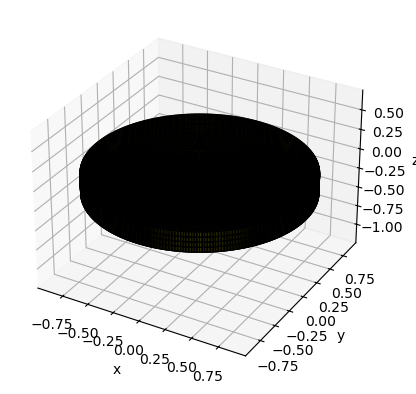

/Users/Bimali/opt/anaconda3/envs/lab/lib/python3.11/site-packages/capytaine/bodies/bodies.py:1135: RuntimeWarning: divide by zero encountered in scalar divide
  p = np.hypot(1/x_span, 1/y_span)


In [4]:
#original  - compound cylinder
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
omega = 2
w = 1
rho = 1023 # density of our special material
wave_amp = 1

result = rb_solve(d, a, 5, 500, rho)

In [ ]:
#really tall  - compound cylinder
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
omega = 2
w = 1
rho = 1023 # density of our special material
wave_amp = 1

result = rb_solve(d, a, 5)

In [ ]:
#staircase  - compound cylinder
h = 1.5
d = [1.1, 0.85, 0.75, 0.4, 0.15]
a = [0.3, 0.5, 1, 1.2, 1.6]
omega = 2
w = 1
rho = 1023 # density of our special material
wave_amp = 1

result = rb_solve(d, a, 5)

In [ ]:
#indents  - compound cylinder
h = 1.9
d = [0.5, 0.7, 0.8, 0.2, 0.5]
a = [0.3, 0.5, 1, 1.2, 1.6]
omega = 1.05
w = 1
rho = 1023 # density of our special material
wave_amp = 1

result = rb_solve(d, a, 5)

In [5]:
# Get potentials
# Define the ranges for R and Z
R_range = np.linspace(0.0, 2*a[-1], num=50)
theta_range = np.linspace(-np.pi, np.pi, num=4)
Z_range = np.linspace(0, -h, num=50) #h

# Create mesh grids for R, theta, and Z
R, theta, Z = np.meshgrid(R_range, theta_range, Z_range, indexing='ij')

# Convert cylindrical coordinates to Cartesian coordinates for capytaine
X = R * np.cos(theta)
Y = R * np.sin(theta)
Z = Z
# Create an array of shape (N, 3)
points = np.zeros((R.size, 3))

# Assign the values of R, Z, and y to the array
points[:, 0] = X.ravel()
points[:, 1] = Y.ravel()
points[:, 2] = Z.ravel()
#need cartesian here
phi_inc = solver.compute_potential(points,result[0]) #rad problem

regions = []
regions.append((R <= a[0]) & (Z > -d[0]))
for i in range(1, len(a)):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))
regions.append(R > a[-1])

# Apply masks to create a blank plot in specified regions
phi_inc = phi_inc.reshape((50,4,50))

for i in range(len(a)):
  phi_inc[regions[i]] = np.nan



In [6]:
vel_inc = solver.compute_velocity(points,result[0])
velx_inc = vel_inc[:,0].reshape((50,4,50))
vely_inc = vel_inc[:,1].reshape((50,4,50))
velz_inc = vel_inc[:,2].reshape((50,4,50))
for i in range(len(a)):
  velx_inc[regions[i]] = np.nan
  vely_inc[regions[i]] = np.nan
  velz_inc[regions[i]] = np.nan

/Users/Bimali/opt/anaconda3/envs/lab/lib/python3.11/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/Bimali/opt/anaconda3/envs/lab/lib/python3.11/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Users/Bimali/opt/anaconda3/envs/lab/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


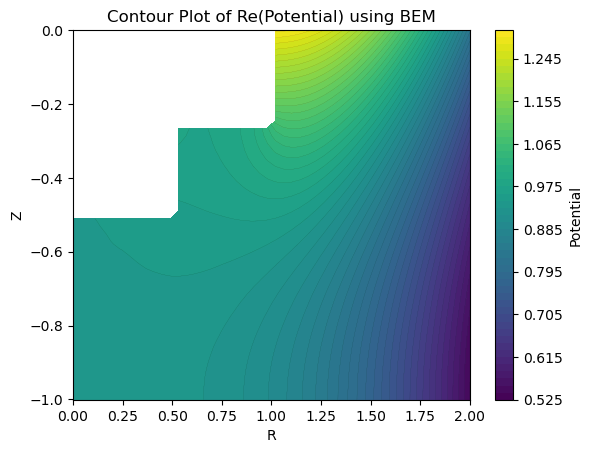

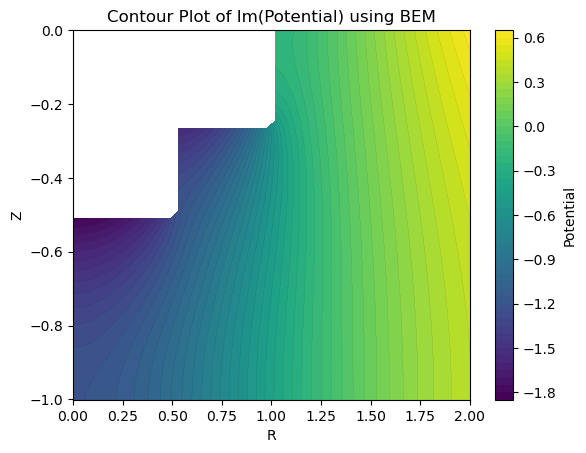

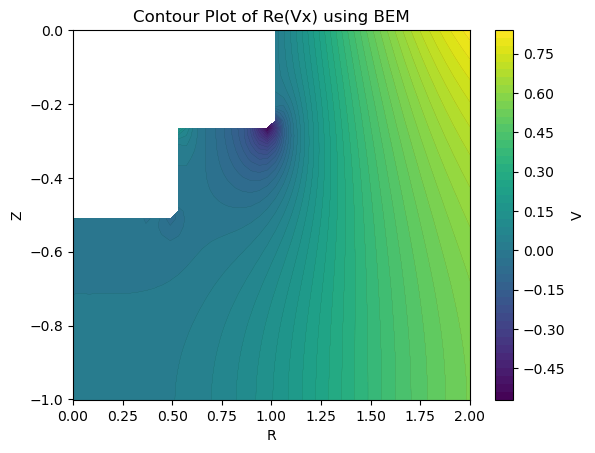

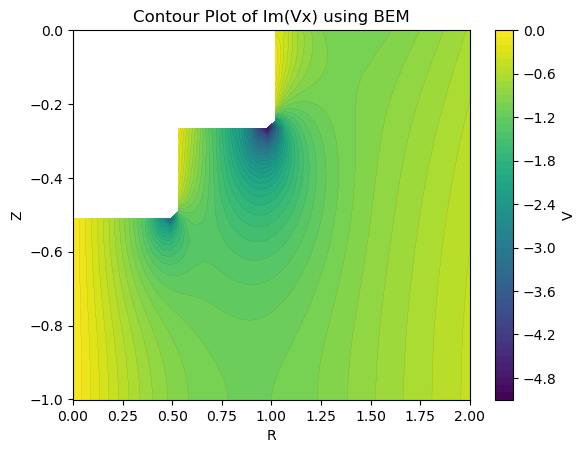

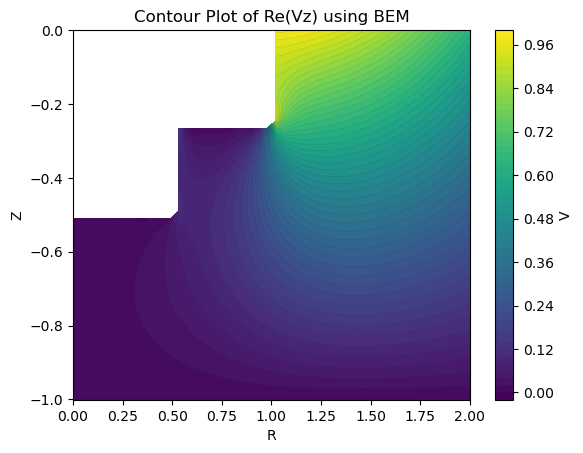

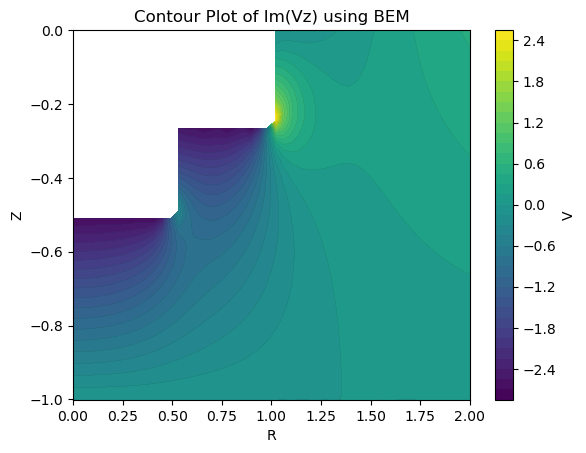

In [7]:
plt.contourf(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Re(Potential) using BEM')

plt.show()

imag_phi_inc = np.imag(phi_inc[:, 0, :])

nan_mask = np.isnan(np.real(phi_inc[:, 0, :]))

np.imag(phi_inc[:, 0, :])[nan_mask] = np.nan

plt.contourf(R[:, 0, :], Z[:, 0, :], imag_phi_inc, cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], imag_phi_inc, colors='black', linestyles='solid', linewidths=0.05,levels=50)


# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Im(Potential) using BEM')

plt.show()

def plot_vel(data, title):
  plt.contourf(R[:, 0, :], Z[:, 0, :], data[:, 0, :], cmap='viridis', levels = 50)
  plt.colorbar(label='V')
  plt.contour(R[:, 0, :], Z[:, 0, :], data[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

  # Add labels and title
  plt.xlabel('R')
  plt.ylabel('Z')
  plt.title(title)

  plt.show()

nan_mask = np.isnan(np.real(velx_inc))

velx_imag = np.imag(velx_inc)
velz_imag = np.imag(velz_inc)

velx_imag[nan_mask] = np.nan
velz_imag[nan_mask] = np.nan

plot_vel(velx_inc, "Contour Plot of Re(Vx) using BEM")
plot_vel(velx_imag, "Contour Plot of Im(Vx) using BEM")
plot_vel(velz_inc, "Contour Plot of Re(Vz) using BEM")
plot_vel(velz_imag, "Contour Plot of Im(Vz) using BEM")


In [8]:
print(result[0].added_mass)
print(result[0].radiation_damping)
print((result[0].added_mass)["Heave"]/(result[0].radiation_damping)["Heave"])

{'Heave': 1582.759778022302}
{'Heave': 3148.8112833973883}
0.502653107973684


In [9]:
def save_potential_array(title, arr):
    file_path = title + "-real" + ".csv"
    np.savetxt(file_path, np.real(arr), delimiter=",", fmt="%.6e")
    file_path = title + "-imag" + ".csv"
    np.savetxt(file_path, np.imag(arr), delimiter=",", fmt="%.6e")

In [10]:
save_potential_array("two-cylinder-heaving", phi_inc[:, 0, :])

In [ ]:
resolution = 0.4

solver = cpt.BEMSolver()
def bemCompoundCylinder(h,a,d,resolution):
  bodies = []
  for i in range(len(a)-1):
    body = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a[i],center=(0,0,-d[i+1] - 0.001),length = d[i] - d[i+1],faces_max_radius=resolution*a[-1])
    bodies.append(body)
  body = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a[-1],center=(0,0,0),length = d[-1],faces_max_radius=resolution*a[-1])
  bodies.append(body)

  #body2 = cpt.meshes.predefined.mesh_vertical_cylinder(radius= a2,center=(0,0,0),length = d2,faces_max_radius=resolution*a2)
  #body1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=a1,center=(0,0,0),length = d1-d2,faces_max_radius=resolution*a2)
  #body1 = body1.translated([0,0,-d2-0.001])

  body = bodies[0]
  for i in range(len(a)-1):
    body = body + bodies[i+1]
  body = cpt.FloatingBody(body)
  body.add_translation_dof(name='Heave')
  body = body.immersed_part()
  #body.show_matplotlib()
  faces_centers = body.mesh.faces_centers

  rad_problem = cpt.RadiationProblem(body=body,
                                        wavenumber = w, water_depth=h)
  results = solver.solve(rad_problem, keep_details = True)
  return results , body.mesh.nb_faces

result = bemCompoundCylinder(h, a, d,resolution)
